### Setup

In [1]:
# Main
import numpy as np
import pandas as pd
import datetime as dt
from statsmodels.tsa.tsatools import lagmat

# Modeling
import statsmodels.api as sm
from statsmodels.tsa.tsatools import add_trend

# Unit root
from arch.unitroot import ADF, DFGLS, PhillipsPerron, KPSS, ZivotAndrews
from quantileADF import QAR, comparisonPlot
from quantileTAR import QTAR, QTAR_CustomRport
from report import countryReport, reportCountries

# Tests and function
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
from statsmodels.regression.linear_model import OLS

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Setup
repoUrl = 'https://raw.githubusercontent.com/vlad-yeghiazaryan/QADF/master/data/'
broadREERsUrl = repoUrl + 'broadREERs.csv'
narrowREERsUrl = repoUrl + 'narrowREERs.csv'
pd.io.formats.excel.ExcelFormatter.header_style = None

In [2]:
def univariate(data):
    univariateTests = pd.DataFrame()
    univariateTests['ADF'] = data.apply(lambda col: ADF(col).pvalue)
    univariateTests['DFGLS'] = data.apply(lambda col: DFGLS(col).pvalue)
    univariateTests['PP'] = data.apply(lambda col: PhillipsPerron(col).pvalue)
    univariateTests['KPSS'] = data.apply(lambda col: KPSS(col).pvalue)
    univariateTests['ZA'] = data.apply(lambda col: ZivotAndrews(col).pvalue)
    return univariateTests.applymap(lambda x: '%.0f' % x if x.is_integer() else '%.3f' % x)

In [3]:
def comparisonPlots(data,fileName='changesOverQuantiles'):
    figs = []
    for index, pos in enumerate(range(0, data.shape[1], 3)):
        columns = data.columns[pos: min(data.shape[1], pos+3)]
        figsize = (len(columns)*5, 6)
        countries = data[columns]
        fig = comparisonPlot(countries, figsize=figsize)
        figs.append(fig)
        plt.savefig(f'Outputs/{fileName}-{index+1}', dpi = 150)
    return figs

In [4]:
def markovRegimeSwitchingPlots(data, fileName='regimeSwitchingProbabilities'):
    figs = []
    for i, pos in enumerate(range(0, data.shape[1], 2)):
        columns = data.columns[pos: min(data.shape[1], pos+2)]
        figsize = (len(columns)*5, 6)
        fig = plt.figure()
        for index, country in enumerate(columns):
            mainModel = QAR(data[country])
            ax = fig.add_subplot(1, len(columns), index+1)
            mod = sm.tsa.MarkovRegression(mainModel.y, trend='c', k_regimes=2, order=2, freq='MS').fit()
            ylabel = 'Probability of being in the high regime'
            title = mainModel.name
            ax = mod.smoothed_marginal_probabilities[1].plot(title=title,ylabel=ylabel, figsize=(12,3))
            ax.axvline('2015-1-1', color='black')
            trans = ax.get_xaxis_transform()
            plt.text('2015-1-1', -.1, 'EAEU', transform=trans, weight='bold')
            ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        figs.append(fig)
        plt.savefig(f'Outputs/{fileName}-{i+1}', dpi = 150)
    return figs

In [5]:
def saveToExcel(dataframe, path, def_properties={}):
    # Setup
    writer = pd.ExcelWriter(path)
    dataframe.style.set_properties(**def_properties).to_excel(writer)

    def dummyCriteria(f): return {'type': 'cell',
                                  'criteria': '!=', 'value': 0, 'format': f}

    def excel_colnum_string(n):
        string = ""
        while n > 0:
            n, remainder = divmod(n - 1, 26)
            string = chr(65 + remainder) + string
        return string

    # Accessing
    workbook = writer.book
    worksheet = writer.sheets['Sheet1']
    colLetter = excel_colnum_string(dataframe.shape[1]+1)
    tableRange = 'A1:'+colLetter+str(dataframe.shape[0]+1)
    header = 'A1:'+colLetter+'1'
    footer = 'A'+str(dataframe.shape[0]+1) + \
        ':'+colLetter+str(dataframe.shape[0]+1)
    indexCol = 'A1:'+'A'+str(dataframe.shape[0]+1)

    # Styles
    defaultFormat = {'font_name': 'Calibri', 'font_size': 8,
                     'bg_color': '#FFFFFF',
                     'align': 'center',
                     'valign': 'vcenter',
                     'border': 0,
                     'shrink': True,
                     'text_wrap': True}
    columnFormat = workbook.add_format(defaultFormat)
    columnFormat.set_font_size(8)
    headerFormat = workbook.add_format(
        {**defaultFormat, **{'top': 5, 'bottom': 2, 'bold': True}})
    footerFormat = workbook.add_format({**defaultFormat, **{'bottom': 5}})
    indexFormat = workbook.add_format({**defaultFormat, **{'align': 'left'}})

    # Applying Styles
    worksheet.conditional_format(tableRange, dummyCriteria(columnFormat))
    worksheet.conditional_format(header, dummyCriteria(headerFormat))
    worksheet.conditional_format(footer, dummyCriteria(footerFormat))
    worksheet.conditional_format(indexCol, dummyCriteria(indexFormat))
    writer.save()
    print('Table saved to:', path)

In [6]:
broadREERs = pd.read_csv(broadREERsUrl, index_col=0, parse_dates=True)
narrowREERs = pd.read_csv(narrowREERsUrl, index_col=0, parse_dates=True)

# Extracting country information
countries = ['Armenia', 'Belarus', 'Kazakhstan', 'Kyrgyz Republic',
             'Moldova', 'Russian Federation', 'Tajikistan', 'Ukraine']

startDate = '2000-01-01'
startDateWithoutTaj = '1995-01-01'

data = broadREERs[countries].loc[startDate:]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2000-01-01 to 2020-11-01
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Armenia             251 non-null    float64
 1   Belarus             251 non-null    float64
 2   Kazakhstan          251 non-null    float64
 3   Kyrgyz Republic     251 non-null    float64
 4   Moldova             251 non-null    float64
 5   Russian Federation  251 non-null    float64
 6   Tajikistan          251 non-null    float64
 7   Ukraine             251 non-null    float64
dtypes: float64(8)
memory usage: 17.6 KB


In [7]:
# renormalize REERs at 2000q1 = 100
data = 100*data/data.iloc[0,:]

# Changing data
dataLogs = data.apply(np.log, axis=1)
dataPtC = dataLogs.diff()[1:]

### REERs of EAEU countries

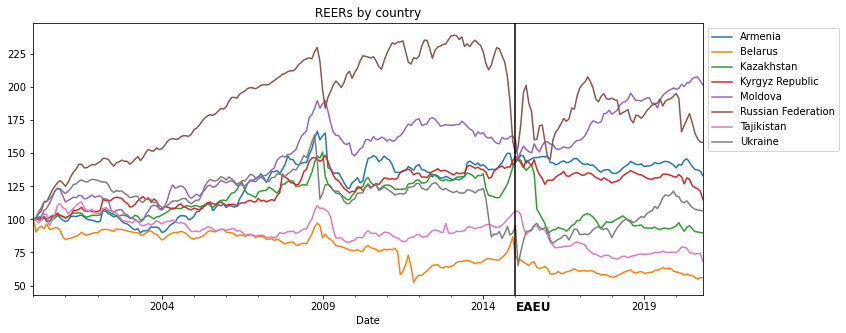

In [8]:
ax = data.plot(kind='line', subplots=False, sharey=True, 
          layout=(1,1), figsize=(12, 5), title='REERs by country', legend=False)

ax.legend(bbox_to_anchor=(1, 1), loc='best')
mark = '2015'
ax.axvline(mark+'-1-1', color='black')
ax.text(mark+'-1-1', -0.06, 'EAEU', transform=ax.get_xaxis_transform(), weight='bold', fontsize='large')

# plt.savefig('Outputs/REERsByCountry', dpi = 150, bbox_inches='tight')
plt.show()

In [9]:
colNames = {
    'count': 'N',
    'mean': 'Mean',
    'std': 'St.dev.',
    'min': 'Min.',
    'max': 'Max.',
    '50%': 'Median',
}
tests = ['Jarque-Bera', 'Jarque-Bera (P-value)', 'Skewness', 'Kurtosis']
include = ['N', 'Mean', 'Median', 'Min.', 'Max.', 'St.dev.',
           'Skewness', 'Kurtosis', 'Jarque-Bera', 'Jarque-Bera (P-value)']

# Summary Setup
summaryStatistics = data.describe().T
JB = data.apply(jarque_bera).T
summaryStatistics[tests] = JB
summaryStatistics.rename(columns=colNames, inplace=True)
summaryTable = summaryStatistics[include].applymap(
    lambda x: '%.0f' % x if x.is_integer() else '%.3f' % x)
summaryTable.index.name = 'Countries'
# saveToExcel(summaryTable, path="Outputs/summaryStatistics.xlsx", def_properties={'text-align': 'center'})
summaryTable

,N,Mean,Median,Min.,Max.,St.dev.,Skewness,Kurtosis,Jarque-Bera,Jarque-Bera (P-value)
Countries,,,,,,,,,,
Armenia,251,127.893,136.073,89.885,166.711,19.203,-0.587,1.967,25.576,0.000
Belarus,251,76.005,77.465,52.363,100.000,12.980,-0.112,1.465,25.185,0.000
Kazakhstan,251,112.964,110.288,89.113,150.891,14.922,0.288,1.980,14.334,0.001
Kyrgyz Republic,251,124.777,129.577,100,148.616,12.651,-0.282,1.842,17.350,0.000
Moldova,251,151.165,157.522,98.007,207.601,29.105,-0.105,1.949,12.008,0.002
Russian Federation,251,186.178,189.951,100,239.107,33.331,-0.349,2.303,10.171,0.006
Tajikistan,251,90.412,90.907,68.353,113.193,10.521,-0.078,2.382,4.249,0.119
Ukraine,251,115.008,119.114,65.136,163.976,16.003,-0.365,2.993,5.561,0.062


In [10]:
univariateTable = univariate(dataLogs)
univariateTable.index.name = 'Countries'
# saveToExcel(univariateTable, path='Outputs/univariateTests.xlsx')
univariateTable

,ADF,DFGLS,PP,KPSS,ZA
Countries,,,,,
Armenia,0.450,0.480,0.491,0.000,0.076
Belarus,0.812,0.857,0.656,0.000,0.153
Kazakhstan,0.329,0.098,0.609,0.035,0.000
Kyrgyz Republic,0.221,0.400,0.222,0.000,0.540
Moldova,0.541,0.856,0.582,0.000,0.745
Russian Federation,0.030,0.617,0.024,0.003,0.327
Tajikistan,0.578,0.427,0.795,0.000,0.169
Ukraine,0.301,0.117,0.182,0.002,0.168


/Users/victor_yerz/anaconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/victor_yerz/anaconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


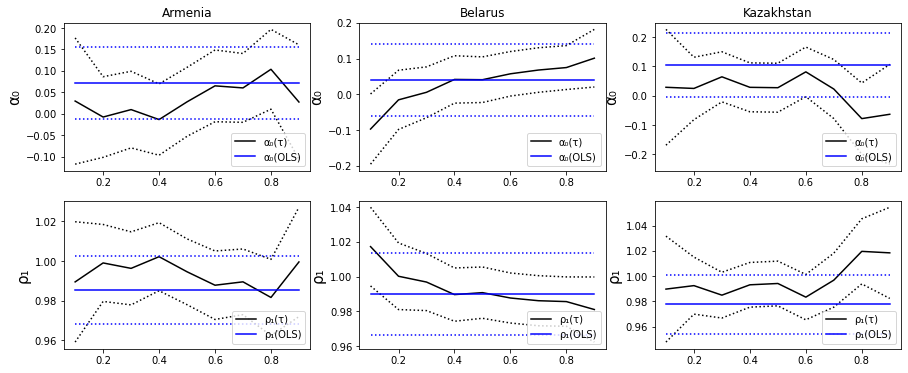

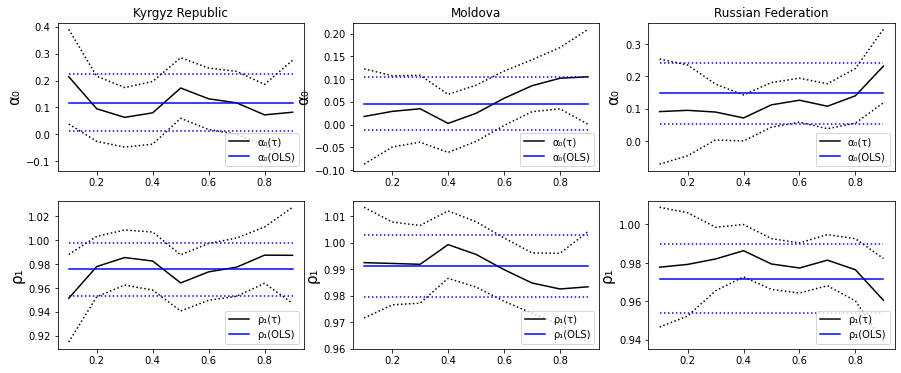

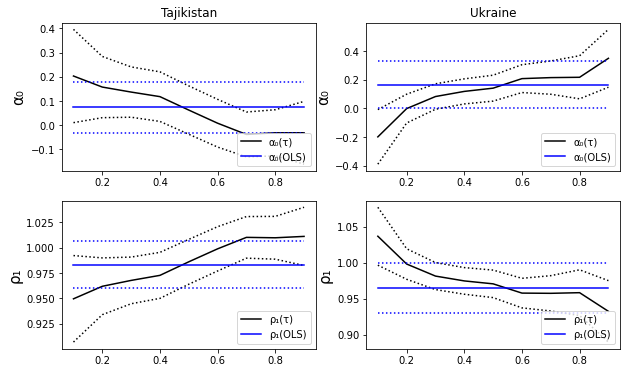

In [11]:
comparisonPlots(dataLogs)
plt.show()

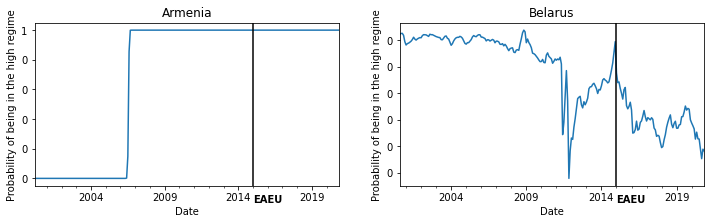

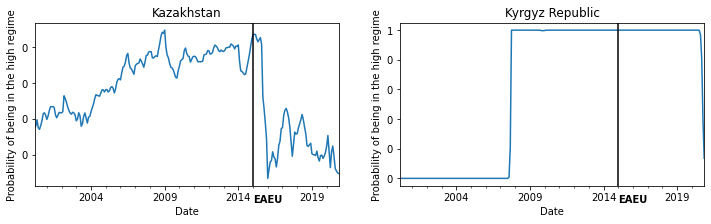

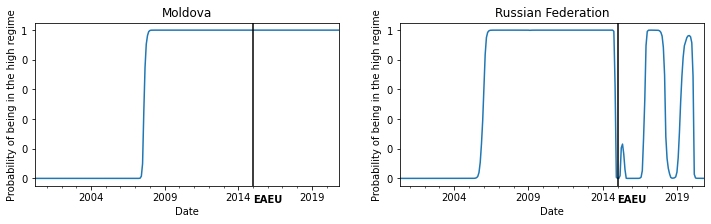

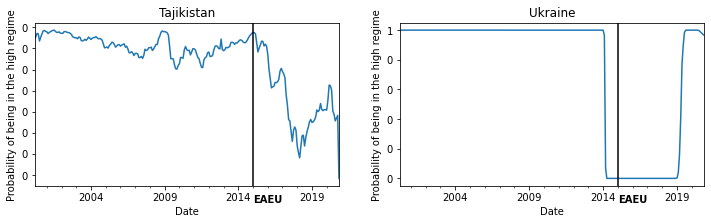

In [12]:
markovRegimeSwitchingPlots(data)
plt.show()

In [13]:
def getCorrespQuant(col, value=100):
    if type(value) != int:
        value = value[col.name]
    return (abs(col-value).idxmin())

data100 = data.quantile(np.arange(0.1, 1, 0.01)).apply(getCorrespQuant, args=[100]).T
data100.name = 'REER=100'

dataEAEU = data.quantile(np.arange(0.1, 1, 0.01)).apply(getCorrespQuant, args=[data.mean()]).T
dataEAEU.name = 'REER=Mean (entire period)'

dataBefore = data.quantile(np.arange(0.1, 1, 0.01)).apply(getCorrespQuant, args=[data.loc[:'2015-1-1'].mean()]).T
dataBefore.name = 'REER=Mean (before EAEU)'

dataAfter = data.quantile(np.arange(0.1, 1, 0.01)).apply(getCorrespQuant, args=[data.loc['2015-1-1':].mean()]).T
dataAfter.name = 'REER=Mean (after EAEU)'

targets = {
    'Armenia': 'N/A',
    'Belarus': 'N/A',
    'Kazakhstan': 'N/A',
    'Kyrgyz Republic': '0.1,0.5',
    'Moldova': '0.7,0.8',
    'Russian Federation': '0.5-0.9*',
    'Tajikistan': '0.1-0.4',
    'Ukraine': '0.4-0.9*'
}

before_targets = {
    'Armenia': 'N/A',
    'Belarus': '0.5-0.9*',
    'Kazakhstan': '0.2',
    'Kyrgyz Republic': '0.1',
    'Moldova': '0.6, 0.8',
    'Russian Federation': 'N/A',
    'Tajikistan': '0.1-0.4*',
    'Ukraine': '0.4-0.7*'
}

after_targets = {
    'Armenia': 'N/A',
    'Belarus': 'N/A',
    'Kazakhstan': '0.1-0.4*',
    'Kyrgyz Republic': '0.7,0.8*',
    'Moldova': '0.9',
    'Russian Federation': '0.5-0.9*',
    'Tajikistan': '0.2-0.7',
    'Ukraine': 'N/A'
}

dataTargets = pd.Series(targets.values(), index=targets.keys(), name='Mean Reversion (entire period)')
EAEU_beforeTargets = pd.Series(before_targets.values(), index=before_targets.keys(), name='Mean Reversion (before EAEU)')
EAEU_afterTargets = pd.Series(after_targets.values(), index=after_targets.keys(), name='Mean Reversion (after EAEU)')

# Constructing the table
meanBehavior = pd.concat([data100, dataEAEU, dataBefore, dataAfter, 
                          EAEU_beforeTargets, EAEU_afterTargets, dataTargets], axis=1)
meanBehavior.index.name = 'Countries'
# saveToExcel(meanBehavior, path='Outputs/meanBehavior.xlsx')
meanBehavior

,REER=100,REER=Mean (entire period),REER=Mean (before EAEU),REER=Mean (after EAEU),Mean Reversion (before EAEU),Mean Reversion (after EAEU),Mean Reversion (entire period)
Countries,,,,,,,
Armenia,0.13,0.34,0.32,0.73,N/A,N/A,N/A
Belarus,0.99,0.46,0.57,0.19,0.5-0.9*,N/A,N/A
Kazakhstan,0.23,0.53,0.58,0.25,0.2,0.1-0.4*,N/A
Kyrgyz Republic,0.10,0.42,0.39,0.66,0.1,"0.7,0.8*","0.1,0.5"
Moldova,0.10,0.41,0.36,0.82,"0.6, 0.8",0.9,"0.7,0.8"
Russian Federation,0.10,0.47,0.48,0.41,N/A,0.5-0.9*,0.5-0.9*
Tajikistan,0.84,0.47,0.68,0.18,0.1-0.4*,0.2-0.7,0.1-0.4
Ukraine,0.22,0.41,0.62,0.20,0.4-0.7*,N/A,0.4-0.9*


### Covergence in subsamples

#### Classic ADF test

In [14]:
adf = ADF(dataLogs['Armenia'])
adf.regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     4.988
Date:                Thu, 01 Jul 2021   Prob (F-statistic):            0.00752
Time:                        15:40:27   Log-Likelihood:                 596.91
No. Observations:                 249   AIC:                            -1188.
Df Residuals:                     246   BIC:                            -1177.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.0147      0.009     -1.664      0.097      -0.032       0.003
Diff.L1        0.1726      0.063      2.753      0.006       0.049       0.296
const          0.0720      0.043      1.684      0.093      -0.012       0.156
==============================================================================
Omnibus:                      128.453   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2270.192
Skew:                          -1.583   Prob(JB):                         0.00
Kurtosis:                      17.450   Cond. No.                         221.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
adf.summary()

Test Statistic,-1.664
P-value,0.450
Lags,1


#### Standard ADF test

In [16]:
# This replicates the results above with the ADF class
lags = 1 # dynamically scalable
diff = dataLogs['Armenia'].diff(1)
d_y = diff[1+lags:]
y_1 = dataLogs['Armenia'].shift(1).rename('Level.L1')
d_y_lags = pd.DataFrame(lagmat(diff, maxlag=lags), index=diff.index,
                        columns=['Diff.L'+str(i) for i in range(1, lags+1)])
X = sm.add_constant(pd.concat([y_1, d_y_lags], axis=1))[1+lags:]
res = OLS(d_y, exog=X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     4.988
Date:                Thu, 01 Jul 2021   Prob (F-statistic):            0.00752
Time:                        15:40:31   Log-Likelihood:                 596.91
No. Observations:                 249   AIC:                            -1188.
Df Residuals:                     246   BIC:                            -1177.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0720      0.043      1.684      0.093      -0.012       0.156
Level.L1      -0.0147      0.009     -1.664      0.097      -0.032       0.003
Diff.L1        0.1726      0.063      2.753      0.006       0.049       0.296
==============================================================================
Omnibus:                      128.453   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2270.192
Skew:                          -1.583   Prob(JB):                         0.00
Kurtosis:                      17.450   Cond. No.                         221.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### ADF test with dummies

In [17]:
# ADF test with pre- and post-EAEU dummies
lags = 1
diff = dataLogs['Armenia'].diff(1)
d_y = diff[1+lags:]
EAEU = (dataLogs.index > '2015-01-01').astype(int)
y_1 = dataLogs['Armenia'].shift(1).rename('Level.L1')
y_1_post = pd.DataFrame(y_1*EAEU).add_suffix('_post')
y_1_pre =  pd.DataFrame(y_1*(1-EAEU)).add_suffix('_pre')
d_y_lags = pd.DataFrame(lagmat(diff, maxlag=lags), index=diff.index,
                        columns=['Diff.L'+str(i) for i in range(1, lags+1)])
X = sm.add_constant(pd.concat([y_1_pre, y_1_post, d_y_lags], axis=1))[1+lags:]
res = OLS(d_y, exog=X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     3.314
Date:                Thu, 01 Jul 2021   Prob (F-statistic):             0.0207
Time:                        15:40:36   Log-Likelihood:                 596.92
No. Observations:                 249   AIC:                            -1186.
Df Residuals:                     245   BIC:                            -1172.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0702      0.048      1.471      0.143      -0.024       0.164
Level.L1_pre     -0.0143      0.010     -1.438      0.152      -0.034       0.005
Level.L1_post    -0.0144      0.010     -1.490      0.138      -0.033       0.005
Diff.L1           0.1722      0.063      2.734      0.007       0.048       0.296
==============================================================================
Omnibus:                      129.114   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2289.170
Skew:                          -1.594   Prob(JB):                         0.00
Kurtosis:                      17.508   Cond. No.                         187.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# ADF test with post-EAEU dummy (Level.L1_post: beta_1 - beta_2 version)
X = sm.add_constant(pd.concat([y_1, y_1_post, d_y_lags], axis=1))[1+lags:]
res = OLS(d_y, exog=X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     3.314
Date:                Thu, 01 Jul 2021   Prob (F-statistic):             0.0207
Time:                        15:40:39   Log-Likelihood:                 596.92
No. Observations:                 249   AIC:                            -1186.
Df Residuals:                     245   BIC:                            -1172.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0702      0.048      1.471      0.143      -0.024       0.164
Level.L1         -0.0143      0.010     -1.438      0.152      -0.034       0.005
Level.L1_post -5.967e-05      0.001     -0.084      0.933      -0.001       0.001
Diff.L1           0.1722      0.063      2.734      0.007       0.048       0.296
==============================================================================
Omnibus:                      129.114   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2289.170
Skew:                          -1.594   Prob(JB):                         0.00
Kurtosis:                      17.508   Cond. No.                         233.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### ADF test with 2 models vs 1 model

In [22]:
# ADF test with 2 models (before/after)
X = sm.add_constant(pd.concat([y_1, d_y_lags], axis=1))[1+lags:]
res = OLS(d_y[:'2015-01-01'], exog=X[:'2015-01-01']).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.140
Date:                Thu, 01 Jul 2021   Prob (F-statistic):             0.0457
Time:                        15:43:48   Log-Likelihood:                 406.99
No. Observations:                 179   AIC:                            -808.0
Df Residuals:                     176   BIC:                            -798.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0668      0.054      1.233      0.219      -0.040       0.174
Level.L1      -0.0136      0.011     -1.203      0.230      -0.036       0.009
Diff.L1        0.1690      0.074      2.276      0.024       0.022       0.316
==============================================================================
Omnibus:                       90.579   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1115.513
Skew:                          -1.518   Prob(JB):                    5.88e-243
Kurtosis:                      14.847   Cond. No.                         194.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# ADF test with 2 models (before/after)
X = sm.add_constant(pd.concat([y_1, d_y_lags], axis=1))[1+lags:]
res = OLS(d_y['2015-01-01':], exog=X['2015-01-01':]).fit()
res.summary()
# Constant is higher in this one

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.389
Date:                Thu, 01 Jul 2021   Prob (F-statistic):              0.256
Time:                        15:45:32   Log-Likelihood:                 214.15
No. Observations:                  71   AIC:                            -422.3
Df Residuals:                      68   BIC:                            -415.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4799      0.313      1.533      0.130      -0.145       1.105
Level.L1      -0.0970      0.063     -1.535      0.129      -0.223       0.029
Diff.L1        0.1117      0.109      1.029      0.307      -0.105       0.328
==============================================================================
Omnibus:                        1.748   Durbin-Watson:                   1.605
Prob(Omnibus):                  0.417   Jarque-Bera (JB):                1.326
Skew:                          -0.332   Prob(JB):                        0.515
Kurtosis:                       3.080   Cond. No.                     1.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### ADF with trend

In [30]:
# In pre- and post-EAEU dummies (as one model) they share the costant. Let's see if adding a trend changes things.
print('One Model with trend')
X = add_trend(pd.concat([y_1_pre, y_1_post, d_y_lags], axis=1), 'ct')[1+lags:]
res = OLS(d_y, exog=X).fit()
res.summary()

One Model with trend


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     3.264
Date:                Thu, 01 Jul 2021   Prob (F-statistic):             0.0125
Time:                        15:56:02   Log-Likelihood:                 598.45
No. Observations:                 249   AIC:                            -1187.
Df Residuals:                     244   BIC:                            -1169.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Level.L1_pre     -0.0372      0.016     -2.259      0.025      -0.070      -0.005
Level.L1_post    -0.0388      0.017     -2.281      0.023      -0.072      -0.005
Diff.L1           0.1862      0.063      2.943      0.004       0.062       0.311
const             0.1718      0.075      2.282      0.023       0.024       0.320
trend          8.982e-05   5.16e-05      1.741      0.083   -1.18e-05       0.000
==============================================================================
Omnibus:                      117.877   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1866.075
Skew:                          -1.433   Prob(JB):                         0.00
Kurtosis:                      16.101   Cond. No.                     8.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
print('Before with trend')
X = add_trend(pd.concat([y_1, d_y_lags], axis=1), 'ct')[1+lags:]
res = OLS(d_y[:'2015-01-01'], exog=X[:'2015-01-01']).fit()
res.summary()

Before with trend


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     3.234
Date:                Thu, 01 Jul 2021   Prob (F-statistic):             0.0236
Time:                        15:56:15   Log-Likelihood:                 408.68
No. Observations:                 179   AIC:                            -809.4
Df Residuals:                     175   BIC:                            -796.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.0448      0.020     -2.192      0.030      -0.085      -0.004
Diff.L1        0.1862      0.074      2.503      0.013       0.039       0.333
const          0.2055      0.093      2.208      0.029       0.022       0.389
trend          0.0001   6.58e-05      1.827      0.069   -9.62e-06       0.000
==============================================================================
Omnibus:                       79.458   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              842.756
Skew:                          -1.312   Prob(JB):                    9.95e-184
Kurtosis:                      13.301   Cond. No.                     5.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
print('After with trend')
X = add_trend(pd.concat([y_1, d_y_lags], axis=1), 'ct')[1+lags:]
res = OLS(d_y['2015-01-01':], exog=X['2015-01-01':]).fit()
res.summary()
# I'll go with a single model with a shared constant, trend and asymmetric adjustments

After with trend


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.683
Date:                Thu, 01 Jul 2021   Prob (F-statistic):             0.0536
Time:                        15:58:09   Log-Likelihood:                 216.76
No. Observations:                  71   AIC:                            -425.5
Df Residuals:                      67   BIC:                            -416.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.1713      0.070     -2.461      0.016      -0.310      -0.032
Diff.L1        0.1516      0.107      1.419      0.161      -0.062       0.365
const          0.8859      0.353      2.509      0.015       0.181       1.591
trend         -0.0002   7.73e-05     -2.259      0.027      -0.000   -2.04e-05
==============================================================================
Omnibus:                        3.682   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.159   Jarque-Bera (JB):                2.887
Skew:                          -0.363   Prob(JB):                        0.236
Kurtosis:                       3.670   Cond. No.                     5.62e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ADF test results

Standard: t-stat = -1.664, p-value = 0.450

Pre-EAEU: t-stat = -1.438

Post-EAEU: t-stat = -1.494

Diff: t-stat = -0.084

### Capturing Convergence

In [30]:
y = data['Belarus']
EAEU = pd.Series((y.index > '2014-12-01').astype(int), index=y.index, name='EAEU')
qtar_model = QTAR(y, EAEU, 'ct', pmax=12, ic='AIC')
res = qtar_model.fit(0.4)

In [31]:
res.regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                Belarus   Pseudo R-squared:               0.8921
Model:                       QuantReg   Bandwidth:                      0.8138
Method:                 Least Squares   Sparsity:                        2.763
Date:                Thu, 01 Jul 2021   No. Observations:                  244
Time:                        22:58:59   Df Residuals:                      234
                                        Df Model:                            9
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    9.3778      1.989      4.714      0.000       5.459      13.297
pre-EAEU_Belarus.L1      0.9000      0.021     43.856      0.000       0.860       0.940
post-EAEU_Belarus.L1     0.8971      0.021     43.038      0.000       0.856       0.938
Diff.L1                  0.1276      0.038      3.385      0.001       0.053       0.202
Diff.L2                 -0.0592      0.042     -1.424      0.156      -0.141       0.023
Diff.L3                  0.0569      0.041      1.390      0.166      -0.024       0.138
Diff.L4                  0.0087      0.043      0.202      0.840      -0.076       0.093
Diff.L5                  0.0268      0.040      0.664      0.507      -0.053       0.106
Diff.L6                 -0.0828      0.037     -2.246      0.026      -0.155      -0.010
trend                   -0.0163      0.004     -4.104      0.000      -0.024      -0.008
========================================================================================

The condition number is large, 3.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
res.summary()
# The critical values don't correspond to this version of the test and will be removed.
# The resampling procedure is robust toward larger pre-tₙ(τ) and post-tₙ(τ).
# I'm still a little concerned if I'm implementing the test correctly.

quantile: 0.4
Lags: 6
α₀(τ): 9.3778
pre-ρ₁(τ): 0.9
post-ρ₂(τ): 0.8971
pre-ρ₁(OLS): 0.9089
post-ρ₂(OLS): 0.8893
ρ₁(τ)-ρ₂(τ): 0.00284
δ²: 0.261
Half-lives: 6.385
pre-tₙ(τ): -20.3959
post-tₙ(τ): -20.7715
CV10%: -2.3095
CV5%: -2.6578
CV1%: -3.3023


In [35]:
quantiles = np.arange(0.1, 1, 0.1)
res.fitForQuantiles(quantiles)

/Users/victor_yerz/anaconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


,Lags,α₀(τ),pre-ρ₁(τ),post-ρ₂(τ),pre-ρ₁(OLS),post-ρ₂(OLS),ρ₁(τ)-ρ₂(τ),δ²,Half-lives,pre-tₙ(τ),post-tₙ(τ),CV10%,CV5%,CV1%,pre-QKS,post-QKS,name
quantile,,,,,,,,,,,,,,,,,
0.1,6,6.2102,0.9151,0.9041,0.9089,0.8893,0.01097,0.322,6.877,-5.6921,-6.3647,-2.4138,-2.7589,-3.3987,20.3959,20.7715,Belarus
0.2,6,10.2852,0.8819,0.8720,0.9089,0.8893,0.00987,0.289,5.061,-15.7010,-16.8481,-2.3598,-2.7078,-3.3522,20.3959,20.7715,Belarus
0.3,6,8.9300,0.9011,0.9020,0.9089,0.8893,-0.00091,0.276,6.721,-15.9493,-15.6493,-2.3368,-2.6849,-3.3294,20.3959,20.7715,Belarus
0.4,6,9.3778,0.9000,0.8971,0.9089,0.8893,0.00284,0.261,6.385,-20.3959,-20.7715,-2.3095,-2.6578,-3.3023,20.3959,20.7715,Belarus
0.5,6,9.4467,0.8998,0.8947,0.9089,0.8893,0.00510,0.250,6.229,-19.4893,-20.2818,-2.2891,-2.6375,-3.2821,20.3959,20.7715,Belarus
0.6,6,7.8761,0.9185,0.9078,0.9089,0.8893,0.01064,0.245,7.166,-15.6021,-17.4667,-2.2811,-2.6296,-3.2742,20.3959,20.7715,Belarus
0.7,6,7.6594,0.9223,0.9030,0.9089,0.8893,0.01928,0.228,6.796,-12.3189,-15.2267,-2.2502,-2.5989,-3.2435,20.3959,20.7715,Belarus
0.8,6,4.8960,0.9528,0.9223,0.9089,0.8893,0.03049,0.200,8.574,-6.8593,-11.1837,-2.1991,-2.5482,-3.1929,20.3959,20.7715,Belarus
0.9,6,3.9735,0.9642,0.9109,0.9089,0.8893,0.05338,0.168,7.424,-2.3992,-5.9224,-2.1205,-2.4718,-3.1207,20.3959,20.7715,Belarus


In [50]:
y = data['Belarus']
y.index.freq = 'MS'
EAEU = pd.Series((y.index > '2014-12-01').astype(int), index=y.index, name='EAEU')
qtar_model = QTAR(y, EAEU, 'ct', pmax=12, ic='AIC')
levels=[0.01,0.05,0.1]
quantiles = np.arange(0.1, 1, 0.1)
drop = ['δ²', 'Lags', 'CV1%', 'CV5%', 'CV10%']
reps = 150

# Should I increase the reps size and remove values of all the models that failed to converge?
from statsmodels.tools.sm_exceptions import IterationLimitWarning
import warnings
warnings.simplefilter('ignore', IterationLimitWarning)

In [51]:
report, results = countryReport(qtar_model, quantiles, reps, levels, 
                                customReport=QTAR_CustomRport, dropColumns=drop)

Belarus finished in: 310.25s


In [52]:
report

quantile                              0.1             0.2             0.3  \
name                                                                        
Belarus α₀(τ)                  6.21(0.26)   10.29(0.027)*    8.93(0.027)*   
        pre-ρ₁(τ)               0.92(0.3)    0.88(0.04)**    0.9(0.033)**   
        post-ρ₂(τ)             0.9(0.233)    0.87(0.04)**    0.9(0.047)**   
        pre-ρ₁(OLS)           0.91(0.173)     0.91(0.173)     0.91(0.173)   
        post-ρ₂(OLS)          0.89(0.08)*     0.89(0.08)*     0.89(0.08)*   
        ρ₁(τ)-ρ₂(τ)            0.011(0.8)     0.0099(0.9)  -0.0009(0.453)   
        Half-lives (years)              1               0               1   
        pre-tₙ(τ)            -5.69(0.333)   -15.7(0.087)*   -15.95(0.113)   
        post-tₙ(τ)           -6.36(0.333)  -16.85(0.073)*   -15.65(0.133)   
        pre-QKS               20.4(0.127)                                   
        post-QKS            20.77(0.093)*                                   

quantile                               0.4             0.5            0.6  \
name                                                                        
Belarus α₀(τ)                9.38(0.007)**   9.45(0.007)**   7.88(0.033)*   
        pre-ρ₁(τ)             0.9(0.027)**   0.9(0.007)***   0.92(0.02)**   
        post-ρ₂(τ)            0.9(0.013)**  0.89(0.007)***   0.91(0.02)**   
        pre-ρ₁(OLS)            0.91(0.173)     0.91(0.173)    0.91(0.173)   
        post-ρ₂(OLS)           0.89(0.08)*     0.89(0.08)*    0.89(0.08)*   
        ρ₁(τ)-ρ₂(τ)          0.0028(0.707)   0.0051(0.813)  0.0106(0.967)   
        Half-lives (years)               1               1              1   
        pre-tₙ(τ)           -20.4(0.047)**   -19.49(0.06)*    -15.6(0.16)   
        post-tₙ(τ)          -20.77(0.04)**  -20.28(0.053)*   -17.47(0.1)*   
        pre-QKS                                                             
        post-QKS                                                            

quantile                              0.7            0.8           0.9  
name                                                                    
Belarus α₀(τ)                7.66(0.047)*      4.9(0.22)   3.97(0.393)  
        pre-ρ₁(τ)            0.92(0.02)**     0.95(0.14)   0.96(0.527)  
        post-ρ₂(τ)          0.9(0.007)***  0.92(0.027)**    0.91(0.14)  
        pre-ρ₁(OLS)           0.91(0.173)    0.91(0.173)   0.91(0.173)  
        post-ρ₂(OLS)          0.89(0.08)*    0.89(0.08)*   0.89(0.08)*  
        ρ₁(τ)-ρ₂(τ)           0.0193(1.0)    0.0305(1.0)   0.0534(1.0)  
        Half-lives (years)              1              1             1  
        pre-tₙ(τ)           -12.32(0.213)   -6.86(0.373)   -2.4(0.547)  
        post-tₙ(τ)          -15.23(0.147)  -11.18(0.153)  -5.92(0.247)  
        pre-QKS                                                         
        post-QKS